In [ ]:
from IMP_CW_env import MESCEnv
import numpy as np 
from scipy.optimize import minimize, basinhopping

from heuristic_policy import HeuristicPolicy, Optimizer
from utils import plot_reward_distribution

import matplotlib.pyplot as plt
%matplotlib inline

# **Training environment definition**

In [2]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

# **Policy optimization**
### Instantiate objects

In [3]:
env_train = MESCEnv(supply_chain_structure, num_periods = 4*7)
sSpolicy = HeuristicPolicy()

### **Run optimization**

In [4]:
from scipy.optimize import Bounds
bounds = Bounds(np.zeros(6), [env_train.retailers[0].order_quantity_limit, # bounds for s_r1
                              env_train.retailers[0].order_quantity_limit, # bounds for S_r1
                              env_train.retailers[1].order_quantity_limit, # bounds for s_r2
                              env_train.retailers[1].order_quantity_limit, # bounds for S_r2
                              env_train.DCs[0].order_quantity_limit, # bounds for s_DC
                              env_train.DCs[0].order_quantity_limit]) # bounds for S_DC

In [5]:
optimizer = Optimizer(sSpolicy.objective_fcn, env_train)
options = None
results = sSpolicy.optimize_policy(env_train, optimizer.calculate_reward, method = 'Powell', bounds=bounds, callback = optimizer.callback, options = options)

Get solution

In [6]:
optimizer.get_best_solution()
optimal_policy_sS = np.clip(np.floor(optimizer.best_x),a_min=0.,a_max=None).astype(int)

In [7]:
print(f'Converged: {results.success}')
print(f'Number of iterations: {optimizer.iter} \nBest objective function value: {optimizer.best_f:.2f}\nMaximum reward: {-1*optimizer.best_f:.2f}\nOptimal (s,S) policy: {optimal_policy_sS}')

Converged: True
Number of iterations: 2 
Best objective function value: -15708.40
Maximum reward: 15708.40
Optimal (s,S) policy: [11 30 20 34 61 76]


Visualize reward evolution

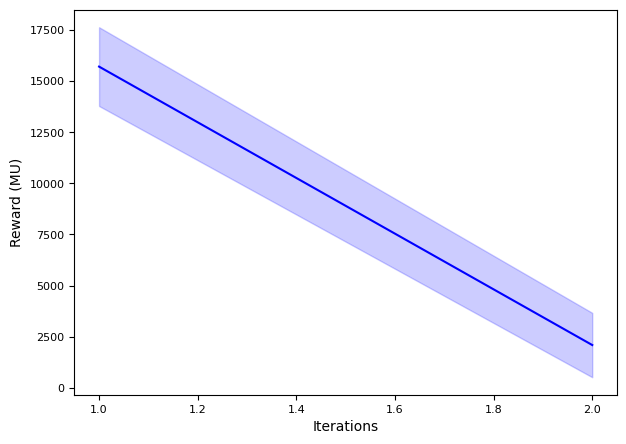

In [8]:
optimizer.plot_learning_curve()

### Compare solution to Bayesian Optimization

In [9]:
from bayes_opt import BayesianOptimization
pbounds = {'s_r1': (0, int(env_train.retailers[0].order_quantity_limit), int), 
           'S_r1': (0, int(env_train.retailers[0].order_quantity_limit), int), 
           's_r2': (0, int(env_train.retailers[1].order_quantity_limit), int), 
           'S_r2': (0, int(env_train.retailers[1].order_quantity_limit), int), 
           's_DC': (0, int(env_train.DCs[0].order_quantity_limit), int), 
           'S_DC': (0, int(env_train.DCs[0].order_quantity_limit), int)}

def objectiveBO(s_r1,S_r1,s_r2,S_r2,s_DC,S_DC):
    
    policy_param = np.array([s_r1,S_r1,s_r2,S_r2,s_DC,S_DC])
    
    num_runs = 3
    total_reward_list = []
    for _ in range(num_runs):
        total_reward = 0
        episode_terminated = False

        env_train.reset()

        if any(policy_param[0::2] >= policy_param[1::2]):
            return -1e8
        else:
            while episode_terminated == False:
                action = sSpolicy.policy_fcn(policy_param, env_train)
                state , reward, episode_terminated, _ = env_train.step(action)
                total_reward += reward
                
        total_reward_list.append(total_reward)
    return np.mean(total_reward_list)

optimizer = BayesianOptimization(
    f= objectiveBO,
    pbounds=pbounds,
    random_state=0,
    verbose = 1,
)
optimizer.maximize(
    init_points = 25,
    n_iter=25
)

best_param_BO = np.clip(np.floor(list(optimizer.max['params'].values())),a_min=0.,a_max=None).astype(int)
print(f"BO optimization results\n- Best return: {optimizer.max['target']}\n- Best param: {best_param_BO}")

C:\Users\Isabela\AppData\Local\Temp\ipykernel_1040\970729144.py:32: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  optimizer = BayesianOptimization(


|   iter    |  target   |   s_r1    |   S_r1    |   s_r2    |   S_r2    |   s_DC    |   S_DC    |
-------------------------------------------------------------------------------------------------
| 2         | 13941.415 | 9         | 19        | 21        | 50        | 36        | 87        |
| 50        | 14636.5   | 0         | 20        | 1         | 31        | 24        | 64        |
BO optimization results
- Best return: 14636.5
- Best param: [ 0 20  1 31 24 64]


# **(s,S) Policy evaluation**

Note that here the policy is tested in the same environment where it was trained.

### Test dataset of demands
It will contain 100 samples for testing, each with `env_train.n_periods` days.

In [10]:
import pickle
# Open the file in binary mode
with open("test_demand_dataset.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### Policy evaluation
Set the optimal policy parameters before running the evaluation.

In [11]:
sSpolicy.policy_param = optimal_policy_sS

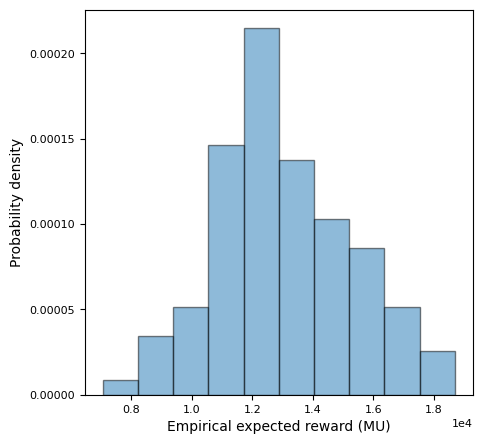

In [12]:
reward_list = sSpolicy.evaluate_policy(env_train, test_demand_dataset)
plot_reward_distribution(reward_list)